In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt
import tilemapbase
import seaborn as sns
from shapely.geometry import MultiPolygon, Polygon

C:\Users\gx826tr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
data = pd.read_csv('prepared_amsterdam_rent.csv')

In [4]:
yelp = pd.read_csv('./data/yelp_businesses.csv')

In [5]:
data.city.value_counts()

amsterdam                  17077
haarlem                     2467
amstelveen                  1497
zaandam                      873
hoofddorp                    872
diemen                       490
weesp                        409
zwanenburg                   370
heemstede                    338
nieuw-vennep                 299
aalsmeer                     267
badhoevedorp                 198
uithoorn                     187
ouderkerk-aan-de-amstel      117
bloemendaal                  109
duivendrecht                  60
Name: city, dtype: int64

In [6]:
#data = data[data['city']=='amsterdam']

In [7]:
data['pps'] = data['price']/data['surface']

In [8]:
ranks = {}
for t in data.type.unique():
    for pt in data.postType.unique():
        df = data[(data['type']==t)&(data['postType']==pt)]
        if len(df) > 0:
            ranks[(t,pt)] = df['pps'].rank()
            ranks[(t,pt)]=(ranks[(t,pt)]-ranks[(t,pt)].min())/(ranks[(t,pt)].max()-ranks[(t,pt)].min())

In [9]:
data['ppsRank'] = 0
for k in ranks:
    data.loc[ranks[k].index,'ppsRank'] = ranks[k]

In [10]:
buurten = gpd.read_file('./data/WijkBuurtkaart_2021_v1.gpkg',layer='cbs_buurten_2021')
wijken = gpd.read_file('./data/WijkBuurtkaart_2021_v1.gpkg',layer='cbs_wijken_2021')
gemeenten = gpd.read_file('./data/WijkBuurtkaart_2021_v1.gpkg',layer='gemeenten2021')

In [11]:
buurten = buurten.set_index(['gemeentecode','wijkcode']).join(wijken.set_index(['gemeentecode','wijkcode'])['wijknaam']).reset_index()

In [12]:
gdata = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
gdata = gdata.set_crs('EPSG:4326')

In [13]:
yelp = yelp[(yelp['latitude']>52.15)&(yelp['latitude']<52.5)&
    (yelp['longitude']>4.45)&(yelp['longitude']<5.2)]

In [14]:
gyelp = gpd.GeoDataFrame(yelp, geometry=gpd.points_from_xy(yelp.longitude, yelp.latitude))
gyelp = gyelp.set_crs('EPSG:4326')

In [15]:
buurten = buurten[['gemeentenaam','wijknaam','buurtnaam','geometry']].copy()
buurten['buurtnaam'] = buurten['buurtnaam'].str.strip().replace('',np.nan)
buurten = buurten.dropna()
buurten = buurten.to_crs('EPSG:4326')

In [16]:
wijken = wijken[['gemeentenaam','wijknaam','geometry']].copy()
wijken['wijknaam'] = wijken['wijknaam'].str.strip().replace('',np.nan)
wijken = wijken.dropna()
wijken = wijken.to_crs('EPSG:4326')

In [17]:
gemeenten = gemeenten[['gemeentenaam','geometry']].copy()
gemeenten['gemeentenaam'] = gemeenten['gemeentenaam'].str.strip().replace('',np.nan)
gemeenten = gemeenten.dropna()
gemeenten = gemeenten.to_crs('EPSG:4326')

In [18]:
#gdata = gpd.sjoin(gdata, gemeenten, predicate='within').drop(columns='index_right')
#gdata = gpd.sjoin(gdata, wijken, predicate='within').drop(columns='index_right')
gdata = gpd.sjoin(gdata, buurten, predicate='within').drop(columns='index_right')

In [19]:
gdata['ppsRank'] = gdata['ppsRank'].astype('float')

In [20]:
colormap = {}
colors = ['#F0E68C','#40E0D0','#FAF0E6','#8B0000','#8B008B',
         '#808080','#E0FFFF','#FF6347','#FFDAB9','#B22222',
         '#00008B','#87CEEB','#FF00FF','#00FA9A','#D3D3D3',
         '#D2B48C','#191970','#BDB76B','#F0F8FF','#FFE4E1',
         '#7FFFD4']

cats = gyelp.category.unique()
for i in range(len(colors)):
    colormap[cats[i]] = colors[i]

In [21]:
gyelp['color'] = gyelp['category'].map(colormap)

In [22]:
gdata

,source,city,postcode,type,price,surface,rooms,latitude,longitude,postType,pps,ppsRank,geometry,gemeentenaam,wijknaam,buurtnaam
0,kamernet,amsterdam,1103SE,apartment,3120.0,120.0,3.0,52.322157,4.981185,Rent,26.000000,0.602029,POINT (4.98118 52.32216),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef
6,kamernet,amsterdam,1103SC,room,700.0,18.0,1.0,52.323582,4.978148,Rent,38.888889,0.335528,POINT (4.97815 52.32358),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef
1547,pararius,amsterdam,1104DB,apartment,1250.0,35.0,2.0,52.320275,4.981223,Rent,35.714286,0.910936,POINT (4.98122 52.32028),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef
3256,pararius,amsterdam,1104DC,apartment,42500.0,90.0,4.0,52.320055,4.982128,Buy,472.222222,0.045746,POINT (4.98213 52.32006),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef
5017,funda,amsterdam,1103SE,house,495000.0,117.0,5.0,52.322157,4.981185,Buy,4230.769231,0.405396,POINT (4.98118 52.32216),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20890,kamernet,haarlem,2033PM,room,500.0,16.0,4.0,52.371074,4.651172,Rent,31.250000,0.184319,POINT (4.65117 52.37107),Haarlem,Slachthuiswijk,Verzetsliedenbuurt
21075,kamernet,haarlem,2034KG,apartment,2250.0,130.0,5.0,52.361232,4.639788,Rent,17.307692,0.152118,POINT (4.63979 52.36123),Haarlem,Europawijk,Schoolenaer
21772,kamernet,amsterdam,1014BV,studio,368.0,20.0,1.0,52.396003,4.850208,Rent,18.400000,0.066768,POINT (4.85021 52.39600),Amsterdam,Westelijk Havengebied,Alfa-driehoek
21930,kamernet,amsterdam,1095KX,studio,600.0,38.0,2.0,52.369815,4.965826,Rent,15.789474,0.025797,POINT (4.96583 52.36982),Amsterdam,Zeeburgereiland/Nieuwe Diep,Zeeburgereiland Zuidoost


<AxesSubplot:>

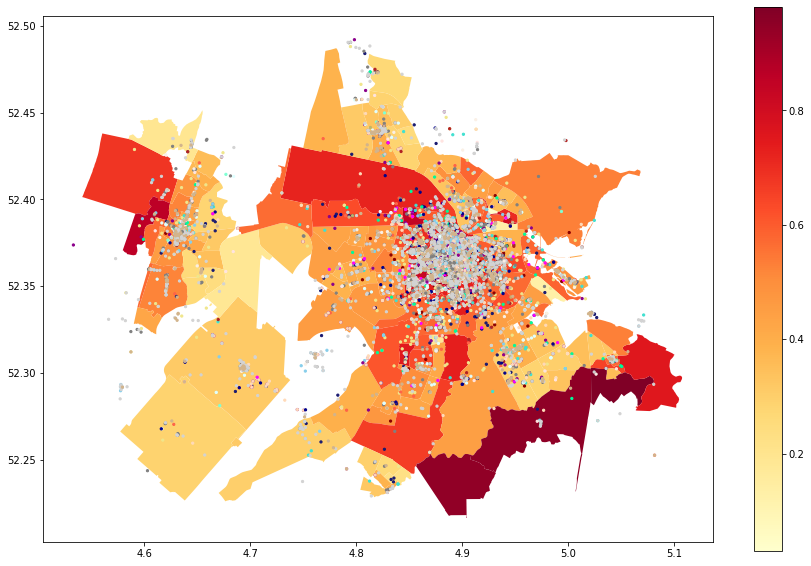

In [23]:
fig, ax = plt.subplots(figsize=(15, 10))
wijken.set_index(['wijknaam','gemeentenaam']).join(gdata.groupby(['wijknaam','gemeentenaam'])['ppsRank'].median(),how='inner').plot(column='ppsRank',cmap='YlOrRd',legend=True,ax=ax)
gyelp.plot(ax=ax,markersize=5,color=gyelp['color'])

<AxesSubplot:>

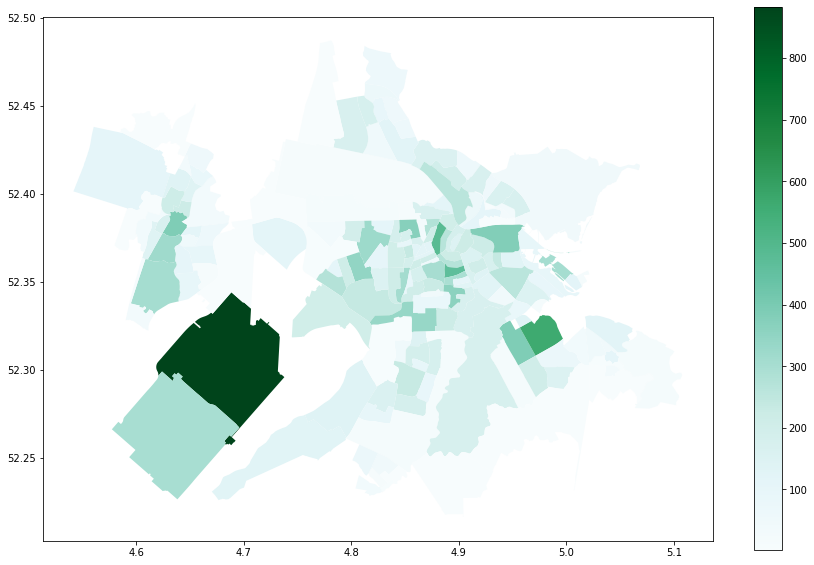

In [24]:
wijken.set_index(['wijknaam','gemeentenaam']).join(gdata.groupby(['wijknaam','gemeentenaam'])['ppsRank'].count(),how='inner').plot(column='ppsRank',cmap='BuGn',figsize=(15, 10),legend=True)

<AxesSubplot:>

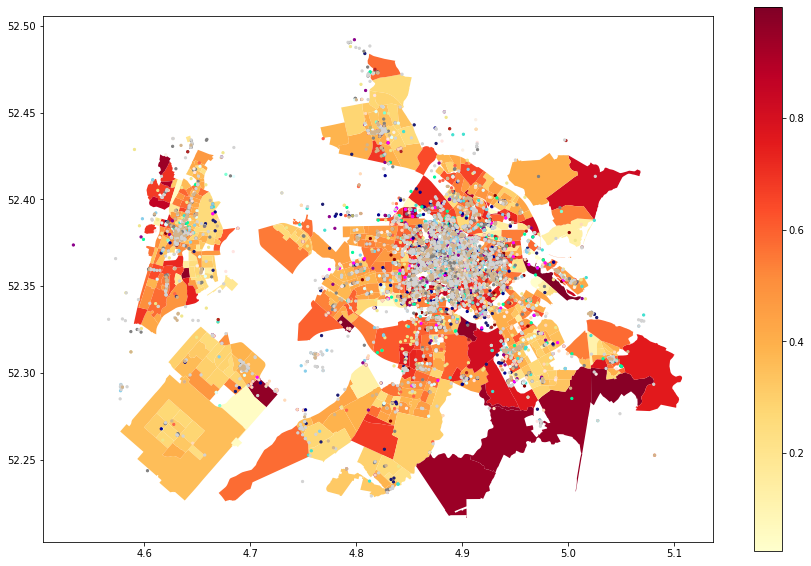

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))
buurten.set_index(['buurtnaam','gemeentenaam']).join(gdata.groupby(['buurtnaam','gemeentenaam'])['ppsRank'].median(),how='inner').plot(column='ppsRank',cmap='YlOrRd',ax=ax,legend=True)
gyelp.plot(ax=ax,markersize=5,color=gyelp['color'])

In [26]:
count = (gdata.groupby(['gemeentenaam','wijknaam','buurtnaam']).count()[['source']]
         .reset_index().set_index(['gemeentenaam','wijknaam']).join(
         gdata.groupby(['gemeentenaam','wijknaam']).count()[['geometry']]))

In [27]:
count = count.rename(columns={
    'source': 'buurt_count',
    'geometry': 'wijk_count'
})

In [28]:
count = count.reset_index()

In [29]:
geometry = count[count['buurt_count']>=15].set_index(['gemeentenaam','wijknaam','buurtnaam'])[[]].join(buurten.set_index(['gemeentenaam','wijknaam','buurtnaam'])).reset_index()

In [30]:
count[count['buurt_count']<15]

,gemeentenaam,wijknaam,buurtnaam,buurt_count,wijk_count
7,Aalsmeer,Wijk 02 Oosteinde,Schinkelpolder,2,138
8,Amstelveen,Amsterdamse Bos,Amsterdamse Bos Noord,5,5
15,Amstelveen,Bovenkerk - Westwijk Noord,Buitenplaatsenbuurt,10,160
17,Amstelveen,Bovenkerk - Westwijk Noord,Legmeer,2,160
19,Amstelveen,Buitengebied Noord,Buurt over Ouderkerk,12,22
...,...,...,...,...,...
694,Zaanstad,Wijk 16 Zaandam Noord,Zaanse Schans,4,65
695,Zaanstad,Wijk 21 Oude Haven,Havenbuurt,2,54
696,Zaanstad,Wijk 21 Oude Haven,Het Eiland,10,54
698,Zaanstad,Wijk 21 Oude Haven,Zuiderhout,1,54


In [31]:
def compute_count(props):
    count = (props.groupby(['gemeentenaam','wijknaam','buurtnaam']).count()[['source']]
                 .reset_index().set_index(['gemeentenaam','wijknaam']).join(
                 props.groupby(['gemeentenaam','wijknaam']).count()[['geometry']]))
    count = count.rename(columns={
                        'source': 'buurt_count',
                        'geometry': 'wijk_count'})
    count = count.reset_index()
    return count

def find_populated_regions(props,buurten,wijken,count_threshold=15):
    no_useful_neighs = pd.DataFrame()
    print('INTRAWIJK')
    while True:
        count = compute_count(props)

        few_props = count[(count['buurt_count']<count_threshold)&(count['wijk_count']>=count_threshold)]
        if len(few_props) != 0:
            row = few_props.iloc[0]
            gem = row['gemeentenaam']
            wik = row['wijknaam']
            brt = row['buurtnaam']
            same_wijk_count = count[(count['gemeentenaam']==gem)&(count['wijknaam']==wik)]
            
            gdf1 = buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik)&(buurten['buurtnaam']==brt)].copy()
            gdf1['geometry'] = gdf1['geometry'].boundary
            gdf2 = buurten[(buurten['gemeentenaam']== gem)&(buurten['wijknaam']==wik)].copy()
            gdf2['geometry'] = gdf2['geometry'].boundary
            
            neighbuurts = gpd.sjoin(gdf1, 
                                    gdf2, predicate='overlaps')[['gemeentenaam_left','wijknaam_left','buurtnaam_right']]
            neighbuurts.columns = ['gemeentenaam','wijknaam','buurtnaam']
            neighbuurts = neighbuurts[neighbuurts['buurtnaam']!=brt]
            indexes = neighbuurts.set_index(['gemeentenaam','wijknaam','buurtnaam']).join(same_wijk_count.set_index(['gemeentenaam','wijknaam','buurtnaam']))['buurt_count'].sort_values().index
            if len(indexes) != 0:
                brt_tojoin = indexes[0][2]
            else:
                print(f'Failed to find neighbour buurt for {brt}')
                no_useful_neighs =  pd.concat([no_useful_neighs,props[(props['gemeentenaam']==gem)&
                                                                     (props['wijknaam']==wik)&
                                                                     (props['buurtnaam']==brt)]])
                props = props[~((props['gemeentenaam']==gem)&
                            (props['wijknaam']==wik)&
                            (props['buurtnaam']==brt))].reset_index(drop=True)
                continue 
                
            jburt = brt_tojoin+' & '+brt

            print(jburt)
            
            try:
            
                united_geometry = MultiPolygon([buurten[(buurten['gemeentenaam']==gem)&
                                   (buurten['wijknaam']==wik)&
                                   (buurten['buurtnaam']==brt)]['geometry'].values[0].union(buurten[(buurten['gemeentenaam']==gem)&
                                   (buurten['wijknaam']==wik)&
                                   (buurten['buurtnaam']==brt_tojoin)]['geometry'].values[0])])

            

            except:
                h1 = buurten[(buurten['gemeentenaam']==gem)&
                            (buurten['wijknaam']==wik)&
                            (buurten['buurtnaam']==brt)]['geometry'].values
                h2 = buurten[(buurten['gemeentenaam']==gem)&
                            (buurten['wijknaam']==wik)&
                            (buurten['buurtnaam']==brt_tojoin)]['geometry'].values
                seq1 = []
                for pol in h1:
                    seq1.extend([i for i in pol.geoms])
                mp1 = MultiPolygon(seq1)
                seq2 = []
                for pol in h2:
                    seq2.extend([i for i in pol.geoms])
                mp2 = MultiPolygon(seq2)
                united_geometry = mp1.union(mp2)
        

            union_data = {'gemeentenaam':[gem],
                     'wijknaam':[wik],
                     'buurtnaam':[jburt],
                     'geometry':[united_geometry]}

            buurten = buurten.drop(index=buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik)&(buurten['buurtnaam']==brt)].index[0]).reset_index(drop=True)
            buurten = buurten.drop(index=buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik)&(buurten['buurtnaam']==brt_tojoin)].index[0]).reset_index(drop=True)

            buurten = gpd.GeoDataFrame(pd.concat([buurten,gpd.GeoDataFrame(union_data)]).reset_index(drop=True))
            #print(type(buurten))
            
            props.reset_index(drop=True,inplace=True)
            
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik)&
                     (props['buurtnaam']==brt), 'buurtnaam'] = jburt
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik)&
                     (props['buurtnaam']==brt_tojoin), 'buurtnaam'] = jburt
            
        else:
            break
            
    props = pd.concat([props,no_useful_neighs])
    no_useful_neighs = pd.DataFrame()

    print('----')
    print('INTERWIJK')
    while True:
        count = compute_count(props)

        few_props = count[(count['buurt_count']<count_threshold)]
        if len(few_props) != 0:
            row = few_props.iloc[0]
            gem = row['gemeentenaam']
            wik = row['wijknaam']
            brt = row['buurtnaam']
            
            gdf1 = buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik)&(buurten['buurtnaam']==brt)].copy()
            gdf1['geometry'] = gdf1['geometry'].boundary
            gdf2 = buurten[(buurten['gemeentenaam']== gem)].copy()
            gdf2['geometry'] = gdf2['geometry'].boundary
            
            neighbuurts = gpd.sjoin(gdf1, gdf2, predicate='overlaps')[['gemeentenaam_left','wijknaam_right','buurtnaam_right']]
            
            neighbuurts.columns = ['gemeentenaam','wijknaam','buurtnaam']
            neighbuurts = neighbuurts[neighbuurts['buurtnaam']!=brt]
            
            indexes = neighbuurts.set_index(['gemeentenaam','wijknaam','buurtnaam']).join(count.set_index(['gemeentenaam','wijknaam','buurtnaam']))['buurt_count'].sort_values().index
            if len(indexes) != 0:
                wik_tojoin = indexes[0][1]
                brt_tojoin = indexes[0][2]
            else:
                print(f'Failed to find neighbour buurt for {brt}')
                no_useful_neighs =  pd.concat([no_useful_neighs,props[(props['gemeentenaam']==gem)&
                                                                     (props['wijknaam']==wik)&
                                                                     (props['buurtnaam']==brt)]])
                props = props[~((props['gemeentenaam']==gem)&
                            (props['wijknaam']==wik)&
                            (props['buurtnaam']==brt))].reset_index(drop=True)
                continue 
                
            jburt = brt_tojoin+' & '+brt
            jwik = wik_tojoin+' & '+wik

            print(jburt)
            
            try:
            
                united_geometry = MultiPolygon([buurten[(buurten['gemeentenaam']==gem)&
                                   (buurten['wijknaam']==wik)&
                                   (buurten['buurtnaam']==brt)]['geometry'].values[0].union(buurten[(buurten['gemeentenaam']==gem)&
                                   (buurten['wijknaam']==wik)&
                                   (buurten['buurtnaam']==brt_tojoin)]['geometry'].values[0])])

            

            except:
                h1 = buurten[(buurten['gemeentenaam']==gem)&
                            (buurten['wijknaam']==wik)&
                            (buurten['buurtnaam']==brt)]['geometry'].values
                h2 = buurten[(buurten['gemeentenaam']==gem)&
                            (buurten['wijknaam']==wik)&
                            (buurten['buurtnaam']==brt_tojoin)]['geometry'].values
                seq1 = []
                for pol in h1:
                    seq1.extend([i for i in pol.geoms])
                mp1 = MultiPolygon(seq1)
                seq2 = []
                for pol in h2:
                    seq2.extend([i for i in pol.geoms])
                mp2 = MultiPolygon(seq2)
                united_geometry = mp1.union(mp2)

            jwik = jwik.split(' & ')
            jwik = ' & '.join(list(set(jwik)))

            union_data = {'gemeentenaam':[gem],
                     'wijknaam':[jwik],
                     'buurtnaam':[jburt],
                     'geometry':[united_geometry]}

            buurten = buurten.drop(index=buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik)&(buurten['buurtnaam']==brt)].index[0]).reset_index(drop=True)
            buurten = buurten.drop(index=buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik_tojoin)&(buurten['buurtnaam']==brt_tojoin)].index[0]).reset_index(drop=True)
            
            buurten = gpd.GeoDataFrame(pd.concat([buurten,gpd.GeoDataFrame(union_data)]).reset_index(drop=True))

            
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik)&
                     (props['buurtnaam']==brt), 'buurtnaam'] = jburt
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik)&
                     (props['buurtnaam']==jburt), 'wijknaam'] = jwik
            
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik_tojoin)&
                     (props['buurtnaam']==brt_tojoin), 'buurtnaam'] = jburt
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik_tojoin)&
                     (props['buurtnaam']==jburt), 'wijknaam'] = jwik
        else:
            break
            
    props = pd.concat([props,no_useful_neighs])
    no_useful_neighs = pd.DataFrame()
    
    print('----')
    print('INTEGEEM')
    while True:
        count = compute_count(props)

        few_props = count[(count['buurt_count']<count_threshold)]
        if len(few_props) != 0:
            row = few_props.iloc[0]
            gem = row['gemeentenaam']
            wik = row['wijknaam']
            brt = row['buurtnaam']
            
            gdf1 = buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik)&(buurten['buurtnaam']==brt)].copy()
            gdf1['geometry'] = gdf1['geometry'].boundary
            gdf2 = buurten.copy()
            gdf2['geometry'] = gdf2['geometry'].boundary
            
            neighbuurts = gpd.sjoin(gdf1, gdf2, predicate='overlaps')[['gemeentenaam_right','wijknaam_right','buurtnaam_right']]
            
            neighbuurts.columns = ['gemeentenaam','wijknaam','buurtnaam']
            neighbuurts = neighbuurts[neighbuurts['buurtnaam']!=brt]
            
            indexes = neighbuurts.set_index(['gemeentenaam','wijknaam','buurtnaam']).join(count.set_index(['gemeentenaam','wijknaam','buurtnaam']))['buurt_count'].sort_values().index
            if len(indexes) != 0:
                gem_tojoin = indexes[0][0]
                wik_tojoin = indexes[0][1]
                brt_tojoin = indexes[0][2]
            else:
                print(f'Failed to find neighbour buurt for {brt}')
                no_useful_neighs =  pd.concat([no_useful_neighs,props[(props['gemeentenaam']==gem)&
                                                                     (props['wijknaam']==wik)&
                                                                     (props['buurtnaam']==brt)]])
                props = props[~((props['gemeentenaam']==gem)&
                            (props['wijknaam']==wik)&
                            (props['buurtnaam']==brt))].reset_index(drop=True)
                continue 
                
            jgem = gem_tojoin+' & '+gem
            jburt = brt_tojoin+' & '+brt
            jwik = wik_tojoin+' & '+wik

            print(jburt)
            
            try:
                united_geometry = MultiPolygon([buurten[(buurten['gemeentenaam']==gem)&
                                   (buurten['wijknaam']==wik)&
                                   (buurten['buurtnaam']==brt)]['geometry'].values[0].union(buurten[(buurten['gemeentenaam']==gem)&
                                   (buurten['wijknaam']==wik)&
                                   (buurten['buurtnaam']==brt_tojoin)]['geometry'].values[0])])

            except:
                h1 = buurten[(buurten['gemeentenaam']==gem)&
                            (buurten['wijknaam']==wik)&
                            (buurten['buurtnaam']==brt)]['geometry'].values
                h2 = buurten[(buurten['gemeentenaam']==gem)&
                            (buurten['wijknaam']==wik)&
                            (buurten['buurtnaam']==brt_tojoin)]['geometry'].values
                seq1 = []
                for pol in h1:
                    seq1.extend([i for i in pol.geoms])
                mp1 = MultiPolygon(seq1)
                seq2 = []
                for pol in h2:
                    seq2.extend([i for i in pol.geoms])
                mp2 = MultiPolygon(seq2)
                united_geometry = mp1.union(mp2)
                
            jwik = jwik.split(' & ')
            jwik = ' & '.join(list(set(jwik)))

            jgem = jgem.split(' & ')
            jgem = ' & '.join(list(set(jgem)))

            union_data = {'gemeentenaam':[jgem],
                     'wijknaam':[jwik],
                     'buurtnaam':[jburt],
                     'geometry':[united_geometry]}

            buurten = buurten.drop(index=buurten[(buurten['gemeentenaam']==gem)&(buurten['wijknaam']==wik)&(buurten['buurtnaam']==brt)].index[0]).reset_index(drop=True)
            buurten = buurten.drop(index=buurten[(buurten['gemeentenaam']==gem_tojoin)&(buurten['wijknaam']==wik_tojoin)&(buurten['buurtnaam']==brt_tojoin)].index[0]).reset_index(drop=True)

            buurten = gpd.GeoDataFrame(pd.concat([buurten,gpd.GeoDataFrame(union_data)]).reset_index(drop=True))
            
            props.loc[(props['gemeentenaam']==gem)&
                     (props['wijknaam']==wik)&
                     (props['buurtnaam']==brt), 'gemeentenaam'] = jgem
            props.loc[(props['gemeentenaam']==jgem)&
                     (props['wijknaam']==wik)&
                     (props['buurtnaam']==brt), 'buurtnaam'] = jburt
            props.loc[(props['gemeentenaam']==jgem)&
                     (props['wijknaam']==wik)&
                     (props['buurtnaam']==jburt), 'wijknaam'] = jwik
            
            props.loc[(props['gemeentenaam']==gem_tojoin)&
                     (props['wijknaam']==wik_tojoin)&
                     (props['buurtnaam']==brt_tojoin), 'gemeentenaam'] = jgem
            props.loc[(props['gemeentenaam']==jgem)&
                     (props['wijknaam']==wik_tojoin)&
                     (props['buurtnaam']==brt_tojoin), 'buurtnaam'] = jburt
            props.loc[(props['gemeentenaam']==jgem)&
                     (props['wijknaam']==wik_tojoin)&
                     (props['buurtnaam']==jburt), 'wijknaam'] = jwik
        else:
            break
    
    print(f'Number of properties not appendable to region big enough: {len(no_useful_neighs)}')
    props = pd.concat([props,no_useful_neighs])
    count = compute_count(props)
    geometry = count.set_index(['gemeentenaam','wijknaam','buurtnaam'])[[]].join(buurten.set_index(['gemeentenaam','wijknaam','buurtnaam'])).reset_index()
    geometry = gpd.GeoDataFrame(geometry)
    
    return props, geometry, no_useful_neighs





In [32]:
props, geometry, no_useful_neighs = find_populated_regions(props=gdata.copy(),wijken=wijken.copy(),buurten=buurten.copy(),count_threshold=30)

INTRAWIJK
Uiterweg & Hornmeer
Schinkelpolder & Bovenlanden
Schinkelpolder & Bovenlanden & Greenpark
Landschappenbuurt & Buitenplaatsenbuurt
Betsy Perkbuurt & Legmeer
Vredeveldbuurt & Kruiskerkbuurt
Langerhuize & Alpen Rondwegbuurt
Kringloopbuurt & In de Wolkenbuurt
Watercirkelbuurt & Langerhuize & Alpen Rondwegbuurt
Kastanjebuurt & Oude Dorp
Augustinuspark & Startbaanbuurt
Patrimonium & Oranjebuurt
Hemellichamenbuurt & Beroepenbuurt
Kruidenbuurt & De Scheg
Kastelenbuurt & Kruidenbuurt & De Scheg
Diepenbrockbuurt & Beethovenbuurt
Buiksloterbreek & Banne Zuidwest
Buiksloterbreek & Banne Zuidwest & Marjoleinterrein
Vogeltjeswei & Amsterdamse Poort
Vogeltjeswei & Amsterdamse Poort & D-buurt
Huntum & Hakfort/Huigenbos
Huntum & Hakfort/Huigenbos & Hoptille
Vogeltjeswei & Amsterdamse Poort & D-buurt & Huntum & Hakfort/Huigenbos & Hoptille
Grunder/Koningshoef & Bijlmermuseum Noord
G-buurt Noord & E-buurt
G-buurt West & G-buurt Noord & E-buurt
Kelbergen & Gooise Kant
K-buurt Zuidoost & K-buurt 

Verzetsliedenbuurt & Componistenbuurt
Verzetsliedenbuurt & Componistenbuurt & Karolingenbuurt
Kruistochtbuurt & Verzetsliedenbuurt & Componistenbuurt & Karolingenbuurt
Schotervlieland & Burgemeesterskwartier
Sterrenbuurt & De Krim
Sterrenbuurt & De Krim & Sinnevelt
Bomenbuurt-west & Bomenbuurt-oost
Schoterveenpolder & Kweektuinbuurt
Schoterveenpolder & Kweektuinbuurt & Ripperdabuurt
Patrimoniumbuurt & Nelson Mandelabuurt
Meeuwenbuurt & Dietsveld
Roemer Visscherbuurt & Muiderkring
Van der Aart sportpark & Roemer Visscherbuurt & Muiderkring
Van der Aart sportpark & Roemer Visscherbuurt & Muiderkring & Van Aemstelbuurt
Waarderpolder & Sportliedenbuurt
Garenkokerskwartier & Hasselaersbuurt
Badhoevedorp Schuilhoeve & Badhoevedorp Antoniushoeve
Badhoevedorp Dijk & Badhoevedorp Centrum
Badhoevedorp Nieuwe Meer & Badhoevedorp Dijk & Badhoevedorp Centrum
Badhoevedorp Noordoost & Badhoevedorp Nieuwe Meer & Badhoevedorp Dijk & Badhoevedorp Centrum
Badhoevedorp Zuid & Badhoevedorp Omgeving
Badhoev

Kerkpadbuurt & Spanjaardsbergbuurt & Santhaesbuurt & Rijkersparkbuurt & Hofgeest & West-Indische buurt & Eltabuurt & Santpoort-Dorp & Florarondebuurt & Pijlkruidbuurt & Bloemenbuurt & Kerkerinkbuurt
Biezenbuurt & Kerkpadbuurt & Spanjaardsbergbuurt & Santhaesbuurt & Rijkersparkbuurt & Hofgeest & West-Indische buurt & Eltabuurt & Santpoort-Dorp & Florarondebuurt & Pijlkruidbuurt & Bloemenbuurt & Kerkerinkbuurt
Failed to find neighbour buurt for Biezenbuurt & Kerkpadbuurt & Spanjaardsbergbuurt & Santhaesbuurt & Rijkersparkbuurt & Hofgeest & West-Indische buurt & Eltabuurt & Santpoort-Dorp & Florarondebuurt & Pijlkruidbuurt & Bloemenbuurt & Kerkerinkbuurt
De Klomp & Aetsveldsepolder
Bedrijventerrein Van Houten & De Klomp & Aetsveldsepolder
Oostelijke Vechtoever & Bedrijventerrein Van Houten & De Klomp & Aetsveldsepolder
Aetsveld Zuid & Aetsveld Noord & Zuid I
Westerspoor & Westzaan Zuid
----
INTEGEEM
Oostelijke Vechtoever & Bedrijventerrein Van Houten & De Klomp & Aetsveldsepolder & Abcoud

In [33]:
props.groupby(['gemeentenaam','wijknaam','buurtnaam']).count()[['source']].sort_values(by='source')

source
gemeentenaam   wijknaam                  buurtnaam                                                 
Diemen         Diemen Centrum            Studentenflats Rode Kruislaan                            3
Haarlemmermeer Hoofddorp                 Hoofddorp Overbos Noord                                 30
Haarlem        Waarder- en Veerpolder    Waarderpolder & Sportliedenbuurt                        30
Amsterdam      Banne Buiksloot           Banne Noordoost                                         30
               Nieuwmarkt/Lastage        Scheepvaarthuisbuurt                                    30
...                                                                                             ...
               IJburg West               Haveneiland Noordoost                                  132
               Overtoomse Sluis          Cremerbuurt West                                       135
Diemen         Holland Park              Holland Park & Holland Park Zuid & Holland Park...     136
Amsterdam      Middelveldsche Akerpolder De Aker Oost                                           162
               Oude Pijp                 Sarphatiparkbuurt                                      163

[413 rows x 1 columns]

In [285]:
props

,source,city,postcode,type,price,surface,rooms,latitude,longitude,postType,pps,ppsRank,geometry,gemeentenaam,wijknaam,buurtnaam
0,kamernet,amsterdam,1103SE,apartment,3120.0,120.0,3.0,52.322157,4.981185,Rent,26.000000,0.603786,POINT (4.98118 52.32216),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef & Bijlmermuseum Noord
1,kamernet,amsterdam,1103SC,room,700.0,18.0,1.0,52.323582,4.978148,Rent,38.888889,0.335335,POINT (4.97815 52.32358),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef & Bijlmermuseum Noord
2,pararius,amsterdam,1104DB,apartment,1250.0,35.0,2.0,52.320275,4.981223,Rent,35.714286,0.913251,POINT (4.98122 52.32028),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef & Bijlmermuseum Noord
3,pararius,amsterdam,1104DC,apartment,42500.0,90.0,4.0,52.320055,4.982128,Buy,472.222222,0.045449,POINT (4.98213 52.32006),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef & Bijlmermuseum Noord
4,funda,amsterdam,1103SE,house,495000.0,117.0,5.0,52.322157,4.981185,Buy,4230.769231,0.404909,POINT (4.98118 52.32216),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef & Bijlmermuseum Noord
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25290,pararius,zwanenburg,2141XD,house,2150.0,135.0,6.0,52.350187,4.678775,Rent,15.925926,0.188119,POINT (4.67878 52.35019),Haarlem & Haarlemmermeer,Vijfhuizen & Boerhaavewijk & Cruquius & Lijnde...,Geleerdenbuurt & Boerhaavevaart & Romolenpolde...
25291,pararius,zwanenburg,2071RM,house,1950.0,120.0,6.0,52.435461,4.640735,Rent,16.250000,0.196040,POINT (4.64074 52.43546),Velsen & Haarlem,Wijk 07 Santpoort-Zuid & Wijk 08 Velserbroek &...,Van Schendelbuurt & Rivierenbuurt & Schrijvers...
25288,kamernet,diemen,1111XB,room,650.0,14.0,1.0,52.342238,4.971667,Rent,46.428571,0.498720,POINT (4.97167 52.34224),Diemen,Diemen Centrum,Studentenflats Rode Kruislaan
25289,kamernet,diemen,1111XB,room,700.0,14.0,1.0,52.342238,4.971667,Rent,50.000000,0.576772,POINT (4.97167 52.34224),Diemen,Diemen Centrum,Studentenflats Rode Kruislaan


<AxesSubplot:xlabel='source', ylabel='Count'>

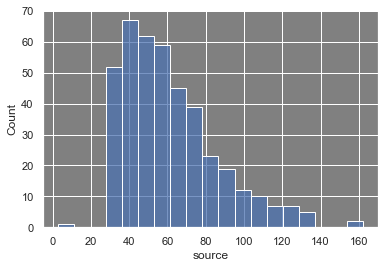

In [276]:
sns.histplot(props.groupby(['gemeentenaam','wijknaam','buurtnaam']).count()[['source']].sort_values(by='source')['source'])

In [277]:
geometry = gpd.GeoDataFrame(geometry)

In [290]:
gdata = gpd.GeoDataFrame(props, geometry=gpd.points_from_xy(props.longitude, props.latitude))
gdata = gdata.set_crs('EPSG:4326')
#gdata = gpd.sjoin(gdata, geometry, predicate='within').drop(columns='index_right')
gdata['ppsRank'] = gdata['ppsRank'].astype('float')

In [291]:
gdata

,source,city,postcode,type,price,surface,rooms,latitude,longitude,postType,pps,ppsRank,geometry,gemeentenaam,wijknaam,buurtnaam
0,kamernet,amsterdam,1103SE,apartment,3120.0,120.0,3.0,52.322157,4.981185,Rent,26.000000,0.603786,POINT (4.98118 52.32216),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef & Bijlmermuseum Noord
1,kamernet,amsterdam,1103SC,room,700.0,18.0,1.0,52.323582,4.978148,Rent,38.888889,0.335335,POINT (4.97815 52.32358),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef & Bijlmermuseum Noord
2,pararius,amsterdam,1104DB,apartment,1250.0,35.0,2.0,52.320275,4.981223,Rent,35.714286,0.913251,POINT (4.98122 52.32028),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef & Bijlmermuseum Noord
3,pararius,amsterdam,1104DC,apartment,42500.0,90.0,4.0,52.320055,4.982128,Buy,472.222222,0.045449,POINT (4.98213 52.32006),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef & Bijlmermuseum Noord
4,funda,amsterdam,1103SE,house,495000.0,117.0,5.0,52.322157,4.981185,Buy,4230.769231,0.404909,POINT (4.98118 52.32216),Amsterdam,"Bijlmer Oost (E,G,K)",Grunder/Koningshoef & Bijlmermuseum Noord
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25290,pararius,zwanenburg,2141XD,house,2150.0,135.0,6.0,52.350187,4.678775,Rent,15.925926,0.188119,POINT (4.67878 52.35019),Haarlem & Haarlemmermeer,Vijfhuizen & Boerhaavewijk & Cruquius & Lijnde...,Geleerdenbuurt & Boerhaavevaart & Romolenpolde...
25291,pararius,zwanenburg,2071RM,house,1950.0,120.0,6.0,52.435461,4.640735,Rent,16.250000,0.196040,POINT (4.64074 52.43546),Velsen & Haarlem,Wijk 07 Santpoort-Zuid & Wijk 08 Velserbroek &...,Van Schendelbuurt & Rivierenbuurt & Schrijvers...
25288,kamernet,diemen,1111XB,room,650.0,14.0,1.0,52.342238,4.971667,Rent,46.428571,0.498720,POINT (4.97167 52.34224),Diemen,Diemen Centrum,Studentenflats Rode Kruislaan
25289,kamernet,diemen,1111XB,room,700.0,14.0,1.0,52.342238,4.971667,Rent,50.000000,0.576772,POINT (4.97167 52.34224),Diemen,Diemen Centrum,Studentenflats Rode Kruislaan


<AxesSubplot:>

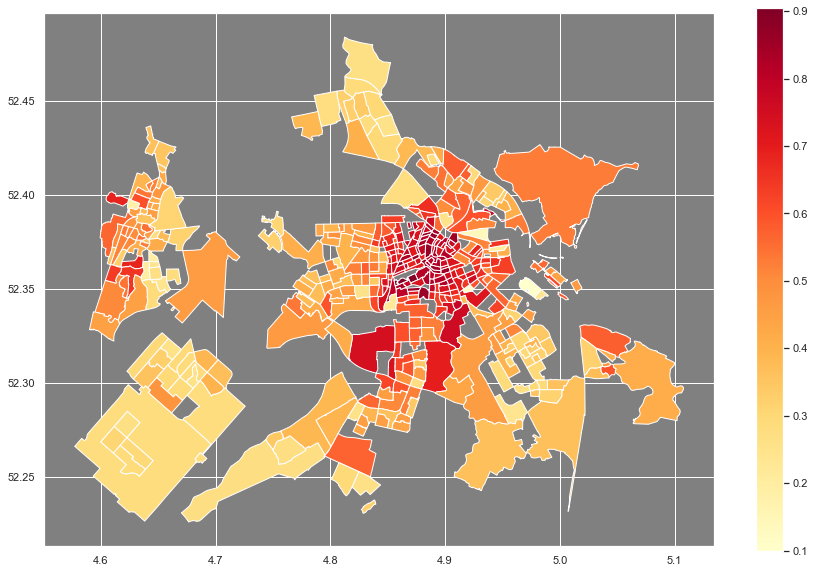

In [292]:
fig, ax = plt.subplots(figsize=(15, 10))
geometry.set_index(['gemeentenaam','wijknaam','buurtnaam']).join(gdata.groupby(['gemeentenaam','wijknaam','buurtnaam'])['ppsRank'].median(),how='inner').plot(column='ppsRank',cmap='YlOrRd',legend=True,ax=ax)
#gyelp.plot(ax=ax,markersize=5,color=gyelp['color'])

In [1]:
sns.set(rc={'axes.facecolor':'grey'})

fig, ax = plt.subplots(figsize=(15, 10))
geometry.set_index(['gemeentenaam','wijknaam','buurtnaam']).join(gdata.groupby(['gemeentenaam','wijknaam','buurtnaam'])['ppsRank'].count(),how='inner').plot(column='ppsRank',vmin=0,cmap='YlGn',legend=True,ax=ax)
#gyelp.plot(ax=ax,markersize=5,color=gyelp['color'])

NameError: name 'sns' is not defined

In [283]:
geometry.set_index(['gemeentenaam','wijknaam','buurtnaam']).join(gdata.groupby(['gemeentenaam','wijknaam','buurtnaam'])['ppsRank'].count(),how='inner').sort_values('ppsRank')

geometry  \
gemeentenaam               wijknaam                                           buurtnaam                                                                                               
Zaanstad                   Wijk 23 Nieuw West & Wijk 81 Westzaan              Westerspoor & Westzaan Zuid                         MULTIPOLYGON (((4.78966 52.44323, 4.79033 52.4...   
Velsen & Haarlem           Wijk 07 Santpoort-Zuid & Wijk 08 Velserbroek & ... Van Schendelbuurt & Rivierenbuurt & Schrijversb...  MULTIPOLYGON (((4.64351 52.43652, 4.64355 52.4...   
Haarlem & Haarlemmermeer   Vijfhuizen & Boerhaavewijk & Cruquius & Lijnden... Geleerdenbuurt & Boerhaavevaart & Romolenpolder...  MULTIPOLYGON (((4.66025 52.34531, 4.66082 52.3...   
Haarlemmermeer             Zwanenburg & Halfweg                               Zwanenburg Omgeving & Zwanenburg Dijk & Zwanenb...  MULTIPOLYGON (((4.75394 52.39121, 4.75471 52.3...   
Amsterdam & De Ronde Venen Baambrugge & Vinkeveen & Waverveen & Abcoude & ... Dorp Driemond & Landelijk gebied Driemond & Abc...  MULTIPOLYGON (((5.01431 52.30367, 5.01440 52.3...   
...                                                                                                                                                                             ...   
Amsterdam                  Erasmuspark                                        Erasmusparkbuurt West                               MULTIPOLYGON (((4.85381 52.37996, 4.85401 52.3...   
                           Overtoomse Sluis                                   Cremerbuurt West                                    MULTIPOLYGON (((4.86391 52.36287, 4.86411 52.3...   
Diemen                     Holland Park                                       Holland Park & Holland Park Zuid & Holland Park...  MULTIPOLYGON (((4.97066 52.32638, 4.97056 52.3...   
Amsterdam                  Oude Pijp                                          Sarphatiparkbuurt                                   MULTIPOLYGON (((4.89926 52.35803, 4.89933 52.3...   
                           Middelveldsche Akerpolder                          De Aker Oost                                        MULTIPOLYGON (((4.79189 52.35304, 4.79239 52.3...   

                                                                                                                                  ppsRank  
gemeentenaam               wijknaam                                           buurtnaam                                                    
Zaanstad                   Wijk 23 Nieuw West & Wijk 81 Westzaan              Westerspoor & Westzaan Zuid                               1  
Velsen & Haarlem           Wijk 07 Santpoort-Zuid & Wijk 08 Velserbroek & ... Van Schendelbuurt & Rivierenbuurt & Schrijversb...        1  
Haarlem & Haarlemmermeer   Vijfhuizen & Boerhaavewijk & Cruquius & Lijnden... Geleerdenbuurt & Boerhaavevaart & Romolenpolder...        1  
Haarlemmermeer             Zwanenburg & Halfweg                               Zwanenburg Omgeving & Zwanenburg Dijk & Zwanenb...        1  
Amsterdam & De Ronde Venen Baambrugge & Vinkeveen & Waverveen & Abcoude & ... Dorp Driemond & Landelijk gebied Driemond & Abc...        2  
...                                                                                                                                   ...  
Amsterdam                  Erasmuspark                                        Erasmusparkbuurt West                                   131  
                           Overtoomse Sluis                                   Cremerbuurt West                                        135  
Diemen                     Holland Park                                       Holland Park & Holland Park Zuid & Holland Park...      136  
Amsterdam                  Oude Pijp                                          Sarphatiparkbuurt                                       160  
                           Middelveldsche Akerpolder                          De Aker Oost                     

In [384]:
gdata.groupby(['gemeentenaam','wijknaam','buurtnaam'])[['ppsRank']].count().sort_values('ppsRank')

ppsRank
gemeentenaam   wijknaam                  buurtnaam                     
Amsterdam      Osdorp-Oost               Calandlaan/Lelylaan         15
               Nieuwmarkt/Lastage        Oosterdokseiland            15
Zaanstad       Wijk 15 Kogerveldwijk     Boerejonkerbuurt            15
Amsterdam      Holendrecht/Reigersbos    Holendrecht Oost            15
Haarlemmermeer Zwanenburg                Zwanenburg Noordoost        15
...                                                                 ...
Amsterdam      Landlust                  Bosleeuw                   122
               Overtoomse Sluis          Cremerbuurt West           124
               Erasmuspark               Erasmusparkbuurt West      125
               Oude Pijp                 Sarphatiparkbuurt          146
               Middelveldsche Akerpolder De Aker Oost               154

[515 rows x 1 columns]

In [385]:
gdata[(gdata['gemeentenaam']=='Zaanstad')&(gdata['wijknaam'].isin(['Wijk 23 Nieuw West','Wijk 81 Westzaan']))]

,source,city,postcode,type,price,surface,rooms,latitude,longitude,postType,pps,ppsRank,geometry,gemeentenaam,wijknaam,buurtnaam
224,kamernet,zaandam,1507XA,room,600.0,11.0,1.0,52.449729,4.798628,Rent,54.545455,0.664611,POINT (4.79863 52.44973),Zaanstad,Wijk 23 Nieuw West,Westerwatering
1177,funda,zaandam,1507WH,house,1577.0,133.0,5.0,52.449065,4.800261,Rent,11.857143,0.031785,POINT (4.80026 52.44907),Zaanstad,Wijk 23 Nieuw West,Westerwatering
2115,pararius,zaandam,1507RX,house,3500.0,237.0,6.0,52.447243,4.798799,Rent,14.767932,0.132029,POINT (4.79880 52.44724),Zaanstad,Wijk 23 Nieuw West,Westerwatering
4213,pararius,zaandam,1507TC,house,56000.0,160.0,6.0,52.439545,4.806954,Buy,350.000000,0.018217,POINT (4.80695 52.43955),Zaanstad,Wijk 23 Nieuw West,Westerwatering
4216,pararius,zaandam,1507JD,house,40000.0,99.0,6.0,52.446556,4.805222,Buy,404.040404,0.050279,POINT (4.80522 52.44656),Zaanstad,Wijk 23 Nieuw West,Westerwatering
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21428,kamernet,zaandam,1507JK,room,500.0,6.0,1.0,52.446133,4.805670,Rent,83.333333,0.939924,POINT (4.80567 52.44613),Zaanstad,Wijk 23 Nieuw West,Westerwatering
21976,kamernet,zaandam,1507SP,room,550.0,10.0,4.0,52.446737,4.799677,Rent,55.000000,0.673762,POINT (4.79968 52.44674),Zaanstad,Wijk 23 Nieuw West,Westerwatering
21991,kamernet,zaandam,1507SN,room,550.0,13.0,1.0,52.445977,4.799810,Rent,42.307692,0.414263,POINT (4.79981 52.44598),Zaanstad,Wijk 23 Nieuw West,Westerwatering
22140,kamernet,zaandam,1507XN,room,550.0,10.0,1.0,52.452535,4.797472,Rent,55.000000,0.673762,POINT (4.79747 52.45254),Zaanstad,Wijk 23 Nieuw West,Westerwatering
